In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import ResNet18_Weights
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [10]:
data_transform = v2.Compose([
    v2.RandomResizedCrop((224,224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=r"C:/Users/celre/Downloads/dataset/Training", transform=data_transform)
val_size = int(0.2 * len(train_dataset))

train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, [len(train_dataset) - val_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

test_dataset = datasets.ImageFolder(root=r"C:/Users/celre/Downloads/dataset/Testing", transform=eval_transform)


train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)



In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [12]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16*61*61, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 4)
        )
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

In [13]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True, min_lr=1e-6)


c:\Users\celre\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
def train(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)

    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss = loss.item()
            curr = batch * batch_size + len(X)
            print(f"loss: {loss:0.2f} [{curr:}/{size:0.2f}]")

def test(dataloader, model, loss_fn, batch_size):
    model.eval()
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg Loss: {test_loss:.2f} \n")

    return correct

In [16]:
best_acc = 0.0
epochs = 50
count = 0
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer, batch_size=32)
    acc = test(val_loader, model, loss_fn, batch_size=32)
    scheduler.step(acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with accuracy: {best_acc:.2f}")
        count = 0
    else:
        count += 1 
        if count == 5:
            print("Early stopping. Model not improving.")
            break


Epoch 1
-------------------------------
loss: 1.48 [32/4570.00]
loss: 0.69 [3232/4570.00]
Test Error: 
 Accuracy: 87.8%, Avg Loss: 0.62 

Best model saved with accuracy: 0.88
Epoch 2
-------------------------------
loss: 0.69 [32/4570.00]
loss: 0.42 [3232/4570.00]
Test Error: 
 Accuracy: 78.1%, Avg Loss: 0.77 

Epoch 3
-------------------------------
loss: 0.58 [32/4570.00]
loss: 0.58 [3232/4570.00]
Test Error: 
 Accuracy: 80.9%, Avg Loss: 0.72 

Epoch 4
-------------------------------
loss: 0.57 [32/4570.00]
loss: 0.55 [3232/4570.00]
Test Error: 
 Accuracy: 91.0%, Avg Loss: 0.54 

Best model saved with accuracy: 0.91
Epoch 5
-------------------------------
loss: 0.52 [32/4570.00]
loss: 0.60 [3232/4570.00]
Test Error: 
 Accuracy: 87.7%, Avg Loss: 0.58 

Epoch 6
-------------------------------
loss: 0.49 [32/4570.00]
loss: 0.44 [3232/4570.00]
Test Error: 
 Accuracy: 90.0%, Avg Loss: 0.56 

Epoch 7
-------------------------------
loss: 0.51 [32/4570.00]
loss: 0.44 [3232/4570.00]
Test Err

In [17]:
model.load_state_dict(torch.load("best_model.pth"))
test_acc = test(test_loader, model, loss_fn, batch_size=32)


C:\Users\celre\AppData\Local\Temp\ipykernel_19408\610953999.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Error: 
 Accuracy: 97.9%, Avg Loss: 0.41 

Test Accuracy: 0.98


C:\Users\celre\AppData\Local\Temp\ipykernel_19408\2233270308.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


              precision    recall  f1-score   support

      glioma      0.980     0.973     0.977       300
  meningioma      0.941     0.990     0.965       306
     notumor      0.995     0.993     0.994       405
   pituitary      1.000     0.957     0.978       300

    accuracy                          0.979      1311
   macro avg      0.979     0.978     0.978      1311
weighted avg      0.980     0.979     0.979      1311



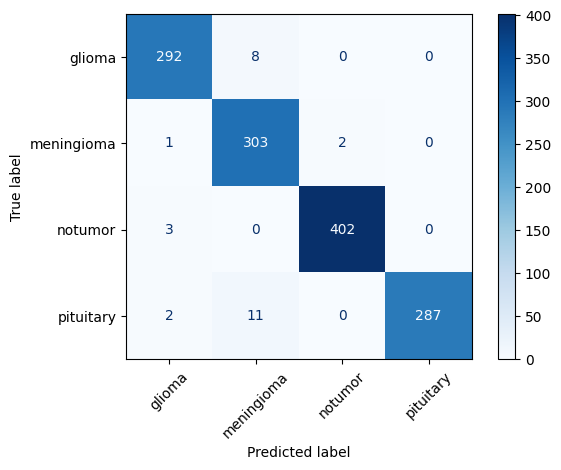

In [20]:


model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for X, y in test_loader:
        preds = model(X.to(device)).argmax(1).cpu()
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

print(classification_report(y_true, y_pred, target_names=test_dataset.classes, digits=3))

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=test_dataset.classes, xticks_rotation=45, cmap="Blues"
)
plt.tight_layout()
plt.show()